In [3]:
import json
import pickle
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
from nltk.corpus import stopwords
from pymystem3 import Mystem
#from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from pymorphy2 import MorphAnalyzer
from bs4 import BeautifulSoup
import glob, os
import tqdm
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt   

Populating the interactive namespace from numpy and matplotlib


In [4]:
df=pd.read_pickle("./df.pkl")

In [5]:
df.head()

,ID,text,mark_1,mark_2,common_mark,text_lemma
0,66542,Добрый день. во время проверки счетчиков горяч...,ПРОЧЕЕ,ПРОЧЕЕ,ПРОЧЕЕ_ПРОЧЕЕ,добрый день время проверка счетчик горячий вод...
1,66539,Добрый день. Не могу войти в личный кабинет. Л...,ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ,НА_РАБОТУ_ЛИЧНОГО_КАБИНЕТА,ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_РАБОТУ_ЛИЧНОГО_КАБИНЕТА,добрый день мочь входить личный кабинет лицево...
2,66538,"Смена собственника лицевого счета, , , ,",ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ,ЗАЯВКА_НА_ИЗМ_ДАННЫХ_ЛИЦЕВОГО_СЧЕТА,ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ЗАЯВКА_НА_ИЗМ_ДАННЫ...,смена собственник лицевой счет
3,66537,"Вы нам ответили, что по перерасчету необходимо...",КОНСУЛЬТАЦИЯ,ПО_ПЛАТЕЖНОМУ_ДОКУМЕНТУ,КОНСУЛЬТАЦИЯ_ПО_ПЛАТЕЖНОМУ_ДОКУМЕНТУ,отвечать перерасчет необходимо предоставлять а...
4,66535,Здравствуйте .Не можем зарегистрироваться в ли...,ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ,НА_РАБОТУ_ЛИЧНОГО_КАБИНЕТА,ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_РАБОТУ_ЛИЧНОГО_КАБИНЕТА,здравствовать мочь зарегистрироваться личный к...


In [6]:
le = preprocessing.LabelEncoder()
le.fit(df.common_mark)
df['marks']=le.transform(df.common_mark)

In [7]:
le.classes_

array(['ДОГОВОРНАЯ_РАБОТА_ЗАКЛЮЧЕНИЕ_ДОГОВОРА', 'ДОГОВОРНАЯ_РАБОТА_ПРОЧЕЕ',
       'ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_КАЧЕСТВО_РАСЧЕТА_СОСТОЯНИЕ СЧЕТА_НАЧИСЛЕНИЯ',
       'ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_ПЕРЕДАЧУ_ПОКАЗАНИЙ',
       'ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_РАБОТУ_ЛИЧНОГО_КАБИНЕТА',
       'ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_ПРОЧЕЕ',
       'ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_УТОЧНЕНИЕ_ПО_ПРОШЛОМУ_ВЗАИМОДЕЙСТВИЮ_С_КОМПАНИЕЙ_ПОВТОРНОЕ ОБРАЩЕНИЕ',
       'КОНСУЛЬТАЦИЯ_ПО_ПЛАТЕЖНОМУ_ДОКУМЕНТУ', 'КОНСУЛЬТАЦИЯ_ПРОЧЕЕ',
       'КОНСУЛЬТАЦИЯ_УТОЧНЕНИЕ_ПО_ПРОШЛОМУ_ВЗАИМОДЕЙСТВИЮ_С_КОМПАНИЕЙ_ПОВТОРНОЕ ОБРАЩЕНИЕ',
       'ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ВОЗВРАТ_ДС',
       'ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ЗАЯВКА_НА_ИЗМ_ДАННЫХ_ЛИЦЕВОГО_СЧЕТА',
       'ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ПЕРЕРАСЧЕТ ',
       'ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ПРИЕМ_ПОКАЗАНИЙ',
       'ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ПРОЧЕЕ',
       'ОПЛАТА_ПОКУПКА_ОПЛАТА_ЗАЯВКИ_НА_ПОКУПКУ_ТОВАРОВ_ДВД',
       'ОПЛАТА_ПОКУПКА_ОПЛАТА_КОММУНАЛЬНЫХ_УСЛУГ', 'ОПЛАТА_ПОКУПКА_ПРОЧЕЕ',
       'ПОЛУЧЕНИЕ_ДОКУМЕНТОВ_П

In [8]:
vectorizer = CountVectorizer(max_features=5000)

X = vectorizer.fit_transform(df.text_lemma).toarray()
y = df.marks

In [9]:
X_train_, X_test_ ,y_train_, y_test_ = train_test_split(df.text, y, random_state=42, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [14]:
%%time
SVC_params = {
          #'kernel':['linear', 'poly','rbf', 'sigmoid', 'precomputed'],
             'C' :[0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}


grid_SVC =   GridSearchCV(SVC(),SVC_params,scoring='f1_micro',
                       cv=3,n_jobs=-1)
grid_SVC.fit(X_train, y_train)
print(grid_SVC.best_params_)
print(grid_SVC.best_score_)
print(grid_SVC.best_estimator_)

/home/gavril/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10, 'gamma': 0.01}
0.499379652605
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
CPU times: user 13.6 s, sys: 148 ms, total: 13.7 s
Wall time: 2min 32s


In [15]:
grid_SVC.score(X_test,y_test)

0.51732673267326734

In [16]:
y_pred=grid_SVC.predict(X_test)

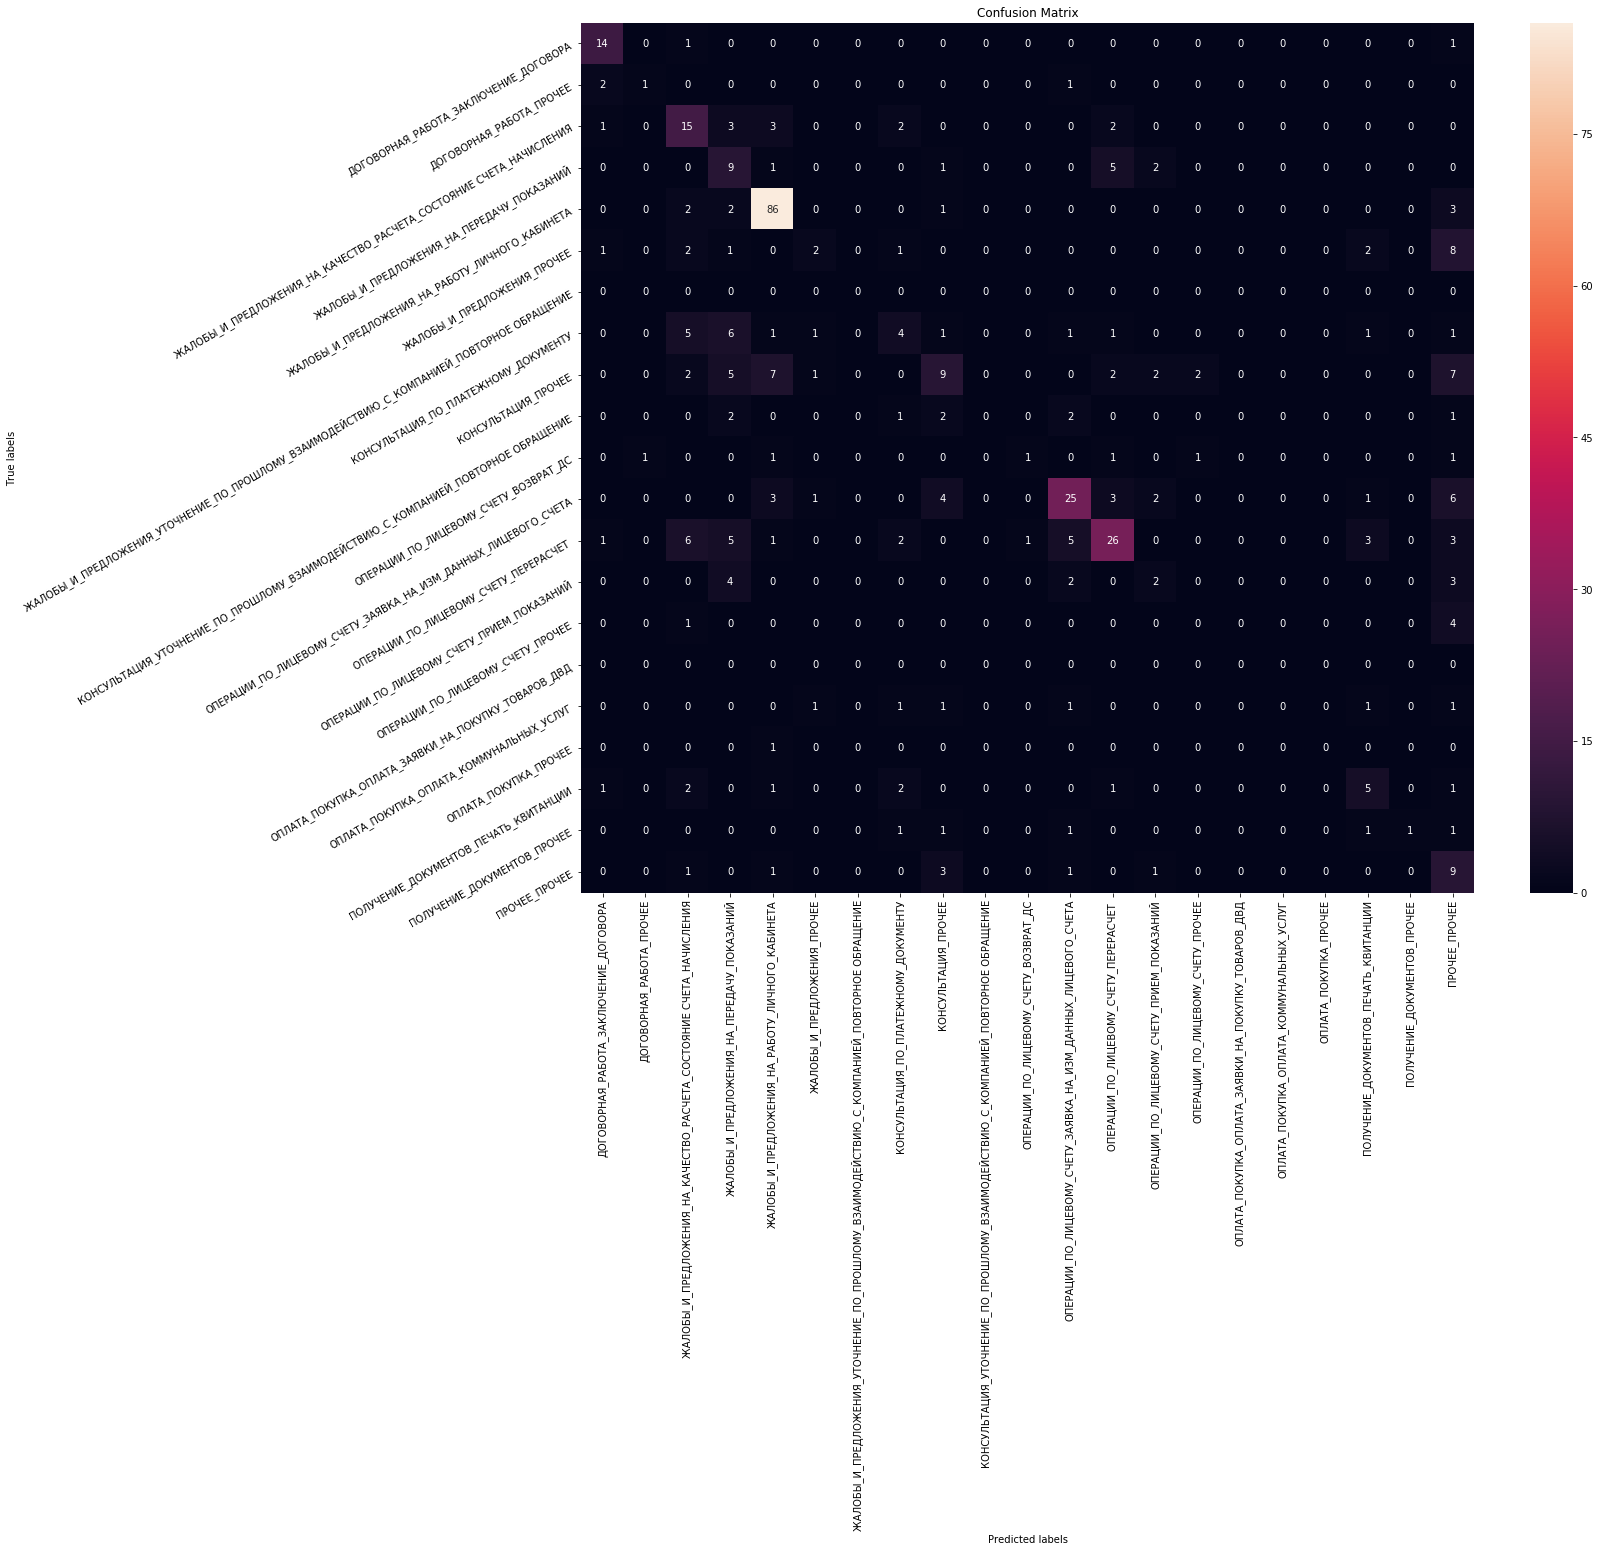

In [17]:
cm = confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_pred),labels=le.classes_)
plt.figure(figsize=(20,16))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(le.classes_,rotation=90);
ax.yaxis.set_ticklabels(le.classes_, rotation=30);

In [18]:
df_ = pd.DataFrame(list(zip(X_test_, le.inverse_transform(y_pred).tolist())), 
               columns =['Initial_text', 'Predicted_class']) 

In [19]:
df_.head(50)

,Initial_text,Predicted_class
0,Прошу сообщить размер задолженности по договор...,КОНСУЛЬТАЦИЯ_ПО_ПЛАТЕЖНОМУ_ДОКУМЕНТУ
1,"Здравствуйте!, Пытался открыть личный кабинет ...",ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_РАБОТУ_ЛИЧНОГО_КАБИНЕТА
2,как передать показания ВТОРОГО счетчика №23628...,ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_ПЕРЕДАЧУ_ПОКАЗАНИЙ
3,"Здравствуйте,подскажите каким образом можно пр...",ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_ПЕРЕДАЧУ_ПОКАЗАНИЙ
4,Замена счетчика электроэнергии на 16 11 2018,КОНСУЛЬТАЦИЯ_ПРОЧЕЕ
5,"Час добрый, купили квартиру, К.Маркса 26/34, к...",ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ЗАЯВКА_НА_ИЗМ_ДАННЫ...
6,"прошу зарегистрировать мой прибор ГВС,для пода...",ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_РАБОТУ_ЛИЧНОГО_КАБИНЕТА
7,Добрый день. Пришел счет за Окт. 18 за комм...,ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_КАЧЕСТВО_РАСЧЕТА_СОСТО...
8,Доброе утро. Оплатила услуги за сентябрь 2018 ...,ЖАЛОБЫ_И_ПРЕДЛОЖЕНИЯ_НА_КАЧЕСТВО_РАСЧЕТА_СОСТО...
9,Прошу внести в программный комплекс компании...,ОПЕРАЦИИ_ПО_ЛИЦЕВОМУ_СЧЕТУ_ЗАЯВКА_НА_ИЗМ_ДАННЫ...


In [41]:
df_.to_csv(r'./export_dataframe.csv',index=False)

In [10]:
final_model=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
final_model.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [12]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

In [13]:
result

0.9133663366336634